# Train a Mini Auto Pilot

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
from keras import models , layers , optimizers , losses , metrics
import keras
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

## Data Visulization

In [2]:
# Load the dataset
X = np.load('x.npy')
y = np.load('y.npy')

last_fram_X = X[: , -1 , : , : , :]
print(X.shape)
print(y.shape)

(208, 5, 240, 320, 1)
(208,)


classfication of labels:<br>
$
\left\{
    \begin{array}{l}
    0 \text{ for } dx < -10 \\ 
    1 \text{ for } -10 \leq dx \leq 10 \\ 
    2 \text{ for } dx > 10 \\ 
    \end{array}
\right.
$

In [3]:
label = np.where(y < -10, 0, np.where(y <= 10, 1, 2))

label

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 0, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 2, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 2, 2, 1, 1, 1, 1, 1])

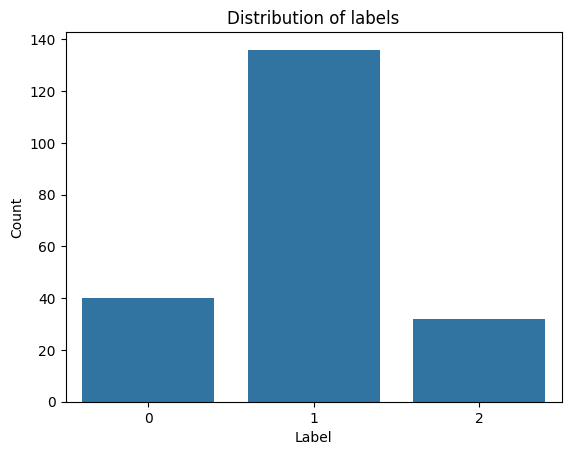

In [4]:
# distribution of label
sns.countplot(x=label)
plt.title('Distribution of labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


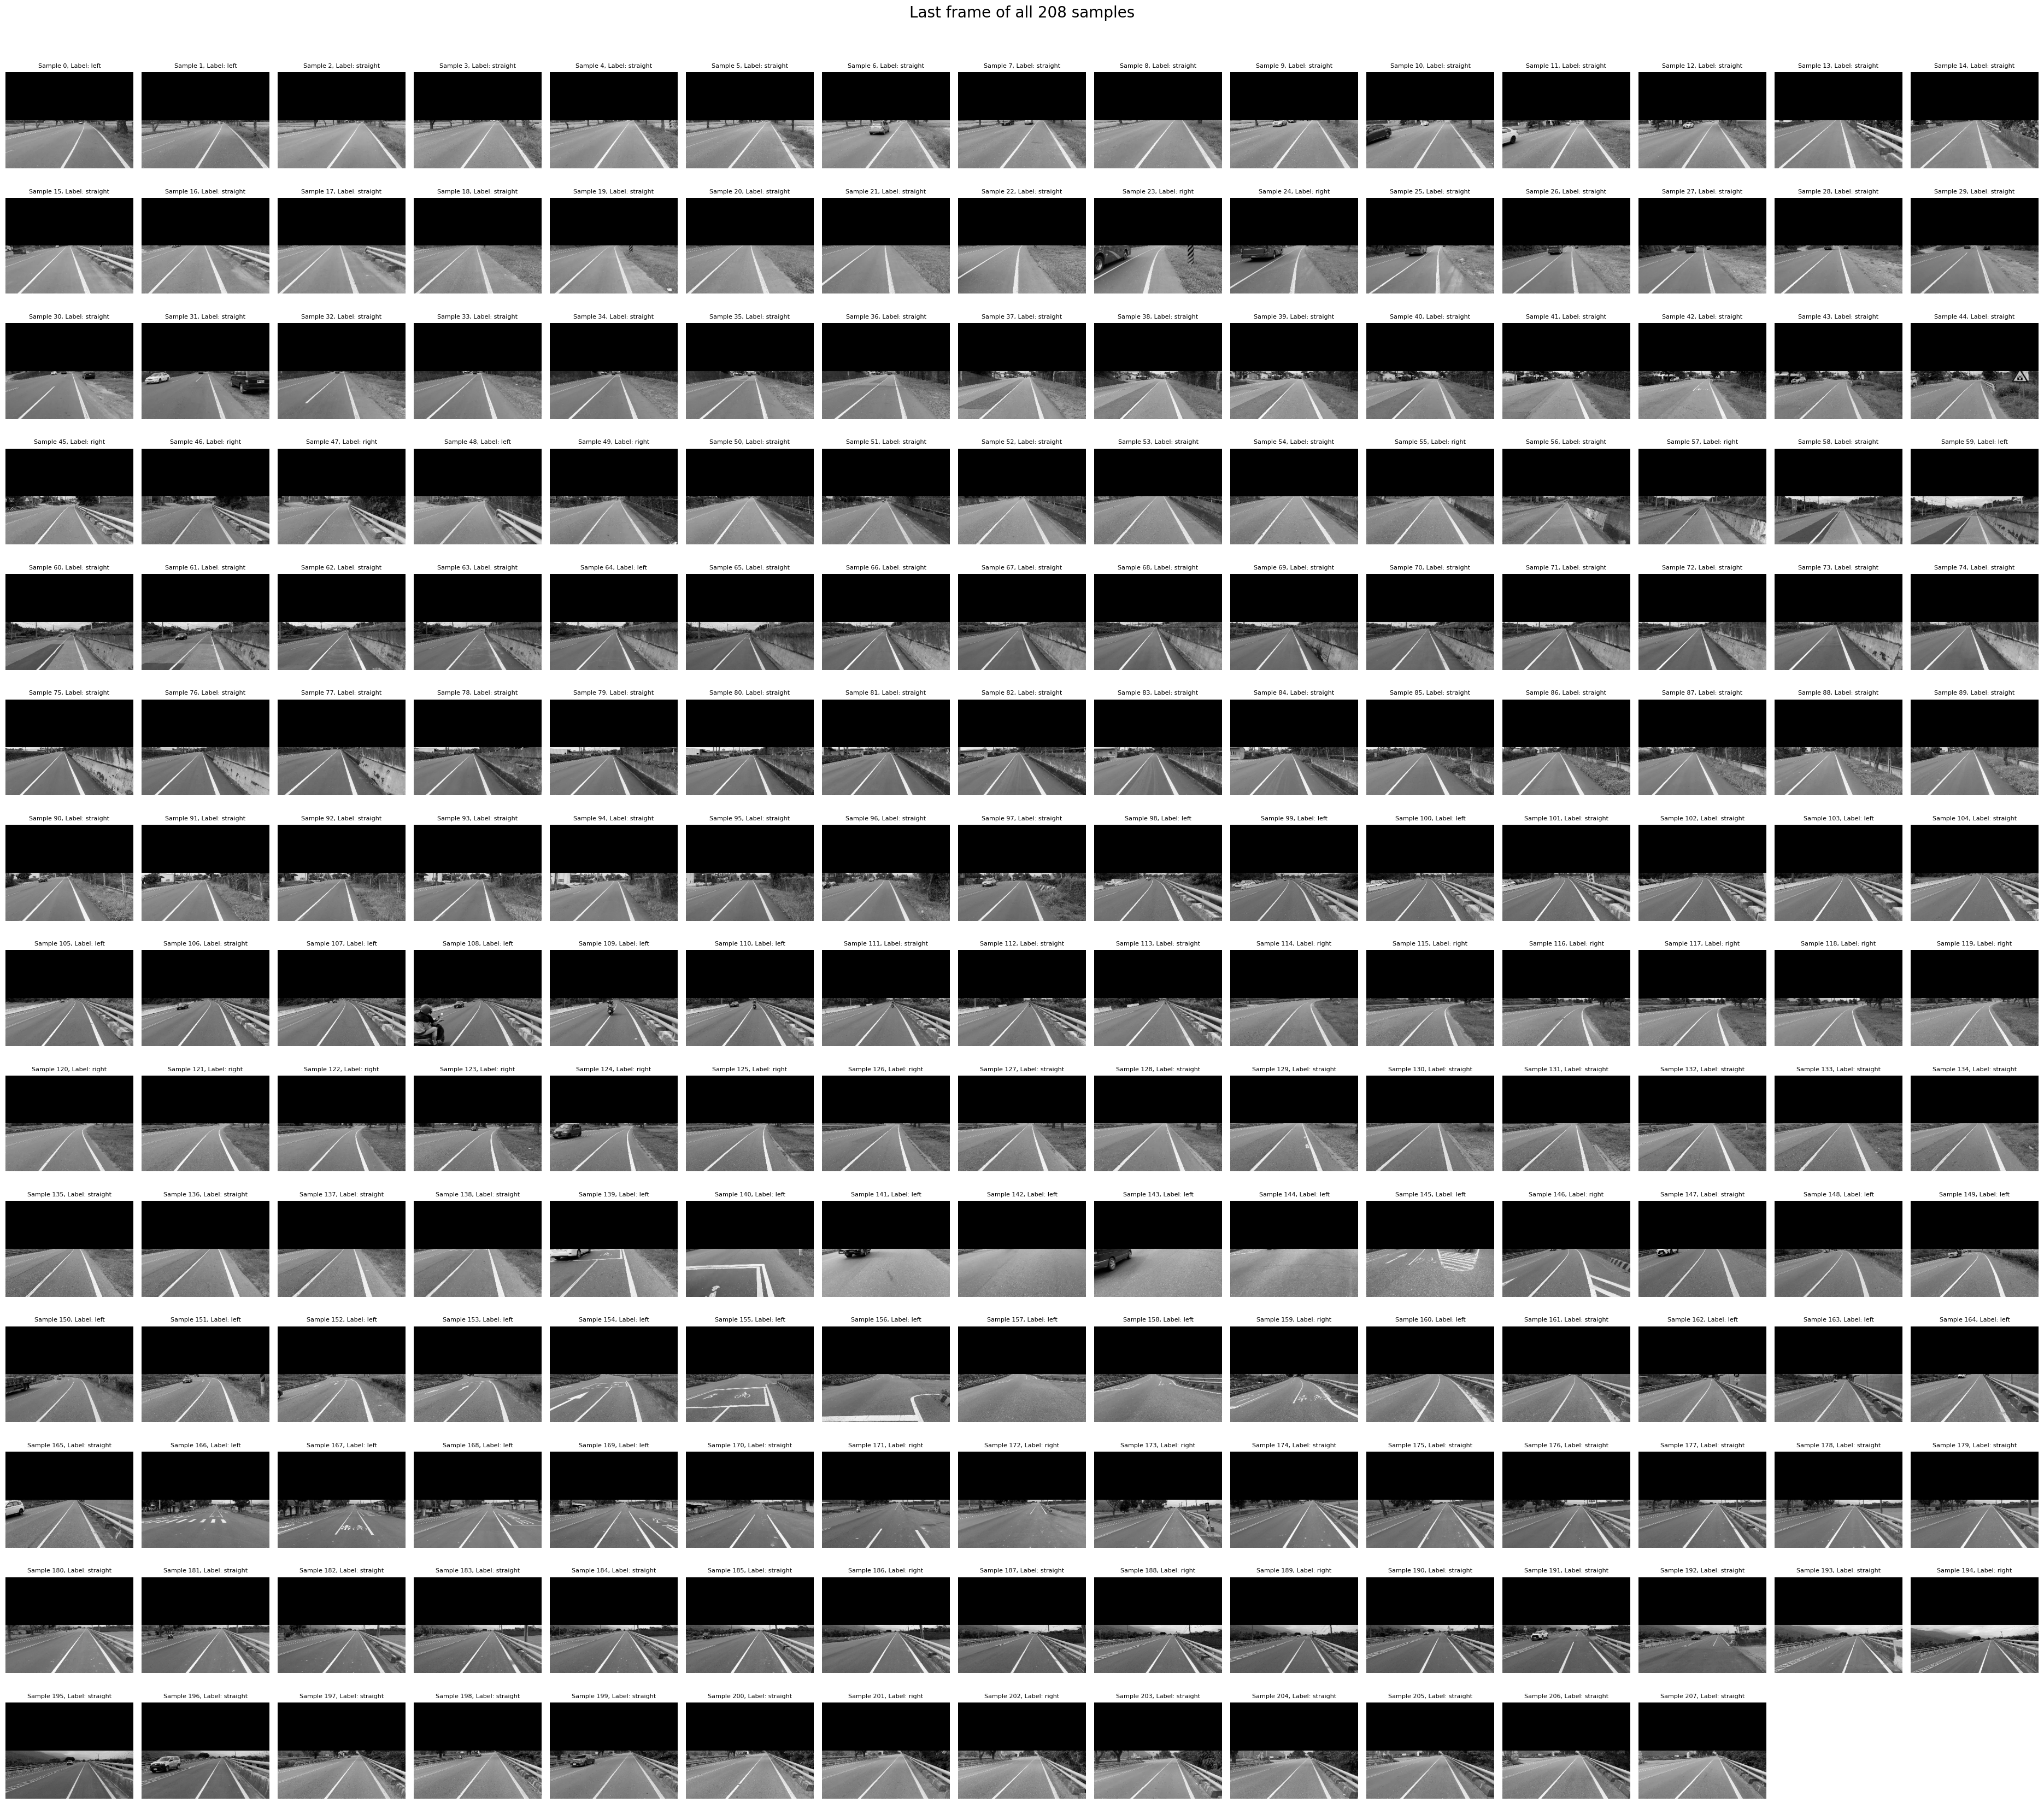

In [5]:
# plot some of the graphs in X
num_samples = len(X)
cols = 15 # Adjust number of columns as desired
rows = int(np.ceil(num_samples / cols))

# Adjust figsize based on the number of rows and columns to make plots visible
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5)) # Increased figsize per subplot
fig.suptitle(f"Last frame of all {num_samples} samples", fontsize=20) # Updated title

label_mapping = {0: "left", 1: "straight", 2: "right"}

# Flatten axes array for easy iteration, handle cases with single row/column
if rows == 1 and cols == 1:
    axes_flat = [axes]
elif rows == 1 or cols == 1:
    axes_flat = axes
else:
    axes_flat = axes.flatten()


for i, ax in enumerate(axes_flat):
    if i < num_samples:  # Iterate through all samples
        frame_to_show = X[i, 4].squeeze()
        ax.imshow(frame_to_show, cmap='gray')
        # Reduced font size for potentially many plots
        ax.set_title(f"Sample {i}, Label: {label_mapping[label[i]]}", fontsize=8)
        ax.axis('off')
    else:
        ax.axis('off') # Hide axes for empty subplots if grid is larger than num_samples

plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout
plt.show()


Found 32 samples with label 'right'.


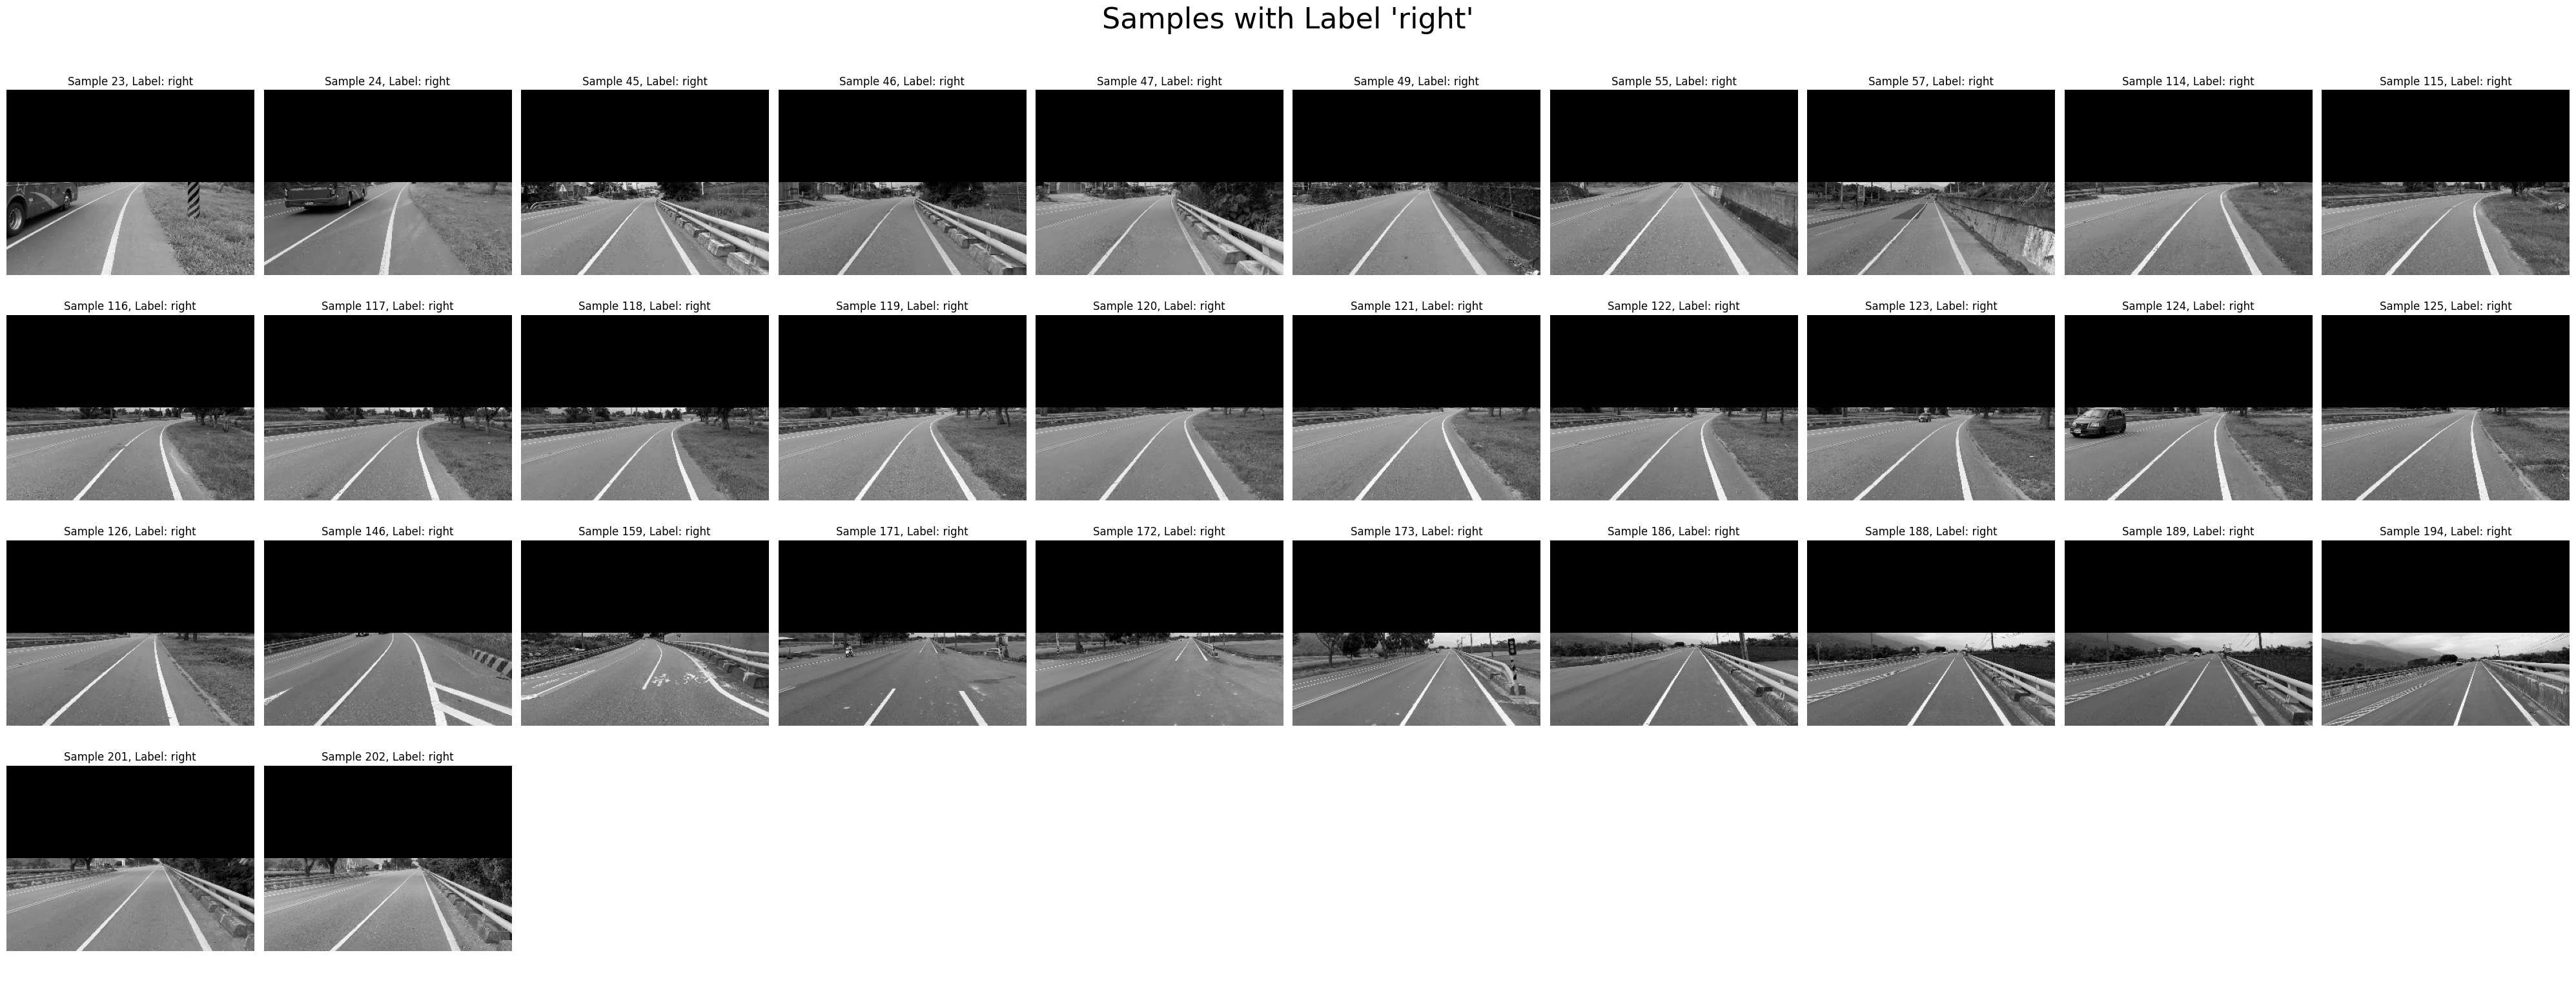

In [6]:
right_indices = np.where(label == 2)[0]
num_right_samples = len(right_indices)

print(f"Found {num_right_samples} samples with label 'right'.")

# Determine grid size for plotting
cols = 10 # Number of columns in the plot grid
rows = int(np.ceil(num_right_samples / cols)) # Calculate required rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4)) # Adjust figsize as needed
fig.suptitle("Samples with Label 'right'", fontsize=32)

# Flatten axes array for easy iteration, handle case where there's only one row/column
if rows == 1 and cols == 1:
    axes_flat = [axes]
elif rows == 1 or cols == 1:
     axes_flat = axes
else:
    axes_flat = axes.flatten()


for i, idx in enumerate(right_indices):
    if i < len(axes_flat): # Ensure we don't plot more images than subplots
        ax = axes_flat[i]
        frame_to_show = X[idx, 4].squeeze()  # Get the last frame of the sequence
        ax.imshow(frame_to_show, cmap='gray')
        ax.set_title(f"Sample {idx}, Label: right", fontsize=12) # Show original index
        ax.axis('off')

# Hide any unused subplots
for j in range(i + 1, len(axes_flat)):
    axes_flat[j].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

<b>Solve class imbalance problem

In [30]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(label),
    y=label
)
print("Class weights:", class_weights)
class_weights_dict = dict(enumerate(class_weights))

Class weights: [1.73333333 0.50980392 2.16666667]


## Construct model

In [43]:
def get_model():
    video_input = layers.Input(shape=(5, 240, 320, 1))
    last_frame_input = layers.Input(shape=(240, 320, 1))

    x1 = layers.Conv3D(8, (3, 5, 5), activation='relu', padding='same', strides=(1, 2, 2))(video_input)
    x1 = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same', strides=(1, 2, 2))(x1)
    x1 = layers.MaxPooling3D((1, 2, 2))(x1)
    x1 = layers.MaxPooling3D((1, 2, 2))(x1)

    x1 = layers.Flatten()(x1)
    x1 = layers.Dense(32, activation='relu')(x1)

    x2 = layers.Conv2D(16, (5, 5), activation='relu', padding='same')(last_frame_input)
    x2 = layers.MaxPooling2D((2, 2))(x2)
    x2 = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(x2)
    x2 = layers.MaxPooling2D((2, 2))(x2)
    x2 = layers.MaxPooling2D((2, 2))(x2)

    x2 = layers.Flatten()(x2)
    x2 = layers.Dense(32, activation='relu')(x2)

    merged = layers.Concatenate()([x1, x2])
    merged = layers.Dense(64, activation='relu')(merged)
    merged = layers.Dropout(0.3)(merged)
    merged = layers.Dense(32, activation='relu')(merged)
    merged = layers.Dropout(0.3)(merged)
    output = layers.Dense(3, activation='softmax')(merged)

    model = models.Model(inputs=[video_input, last_frame_input], outputs=output)

    return model

In [44]:
model = get_model()
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 240, 320,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 5, 240,    │          0 │ -                 │
│ (InputLayer)        │ 320, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 240, 320,  │        416 │ input_layer_9[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_16 (Conv3D)  │ (None, 5, 120,    │        608 │ input_layer_8[0]… │
│                     │ 160, 8)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 120, 160,  │          0 │ conv2d_15[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_17 (Conv3D)  │ (None, 5, 60, 80, │      3,472 │ conv3d_16[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 120, 160,  │     12,832 │ max_pooling2d_20… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_13    │ (None, 5, 30, 40, │          0 │ conv3d_17[0][0]   │
│ (MaxPooling3D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 60, 80,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_14    │ (None, 5, 15, 20, │          0 │ max_pooling3d_13… │
│ (MaxPooling3D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 30, 40,    │          0 │ max_pooling2d_21… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_16          │ (None, 24000)     │          0 │ max_pooling3d_14… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_17          │ (None, 38400)     │          0 │ max_pooling2d_22… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 32)        │    768,032 │ flatten_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 32)        │  1,228,832 │ flatten_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 64)        │          0 │ dense_36[0][0],   │
│ (Concatenate)       │                   │            │ dense_37[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 64)        │      4,160 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 64)        │          0 │ dense_38[0][0]  

 Total params: 2,020,531 (7.71 MB)

 Trainable params: 2,020,531 (7.71 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                loss=losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=[metrics.SparseCategoricalAccuracy(name='accuracy')])

In [46]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
]

In [47]:
history = model.fit(
    [X, last_fram_X],
    label,
    batch_size=32,
    epochs=50,
    validation_split=0.2,
    callbacks=callbacks,
    class_weight=class_weights_dict,
    shuffle=True,
    verbose=1
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 702ms/step - accuracy: 0.2619 - loss: 32.9808 - val_accuracy: 0.0952 - val_loss: 23.1286 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.2722 - loss: 10.4673 - val_accuracy: 0.0952 - val_loss: 1.7312 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.2314 - loss: 1.7758 - val_accuracy: 0.2143 - val_loss: 1.1679 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.2706 - loss: 1.1750 - val_accuracy: 0.6429 - val_loss: 1.0650 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4879 - loss: 1.0663 - val_accuracy: 0.6905 - val_loss: 1.0405 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5159 - loss: 1.1429 - val_accuracy: 0.6905 - val_loss: 1.0450 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4775 - loss: 1.0861 - val_accuracy: 0.6

### Plot Training Process

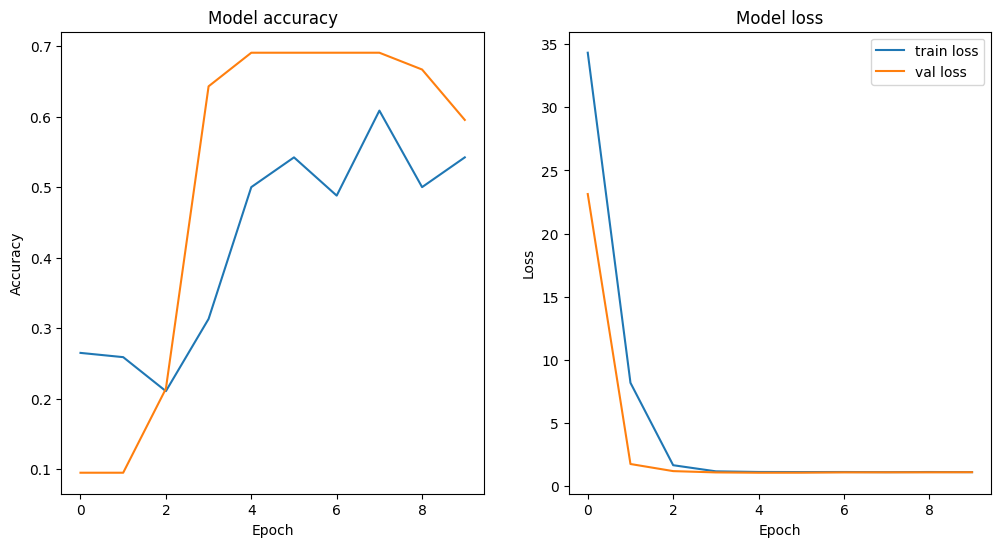

In [48]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()
